# **Practical Course: Image classification with Neural Networks** 

### **Install the required packages**

- Install PyTorch and torchvision for your operating system and CUDA version (https://pytorch.org)
- Install numpy
- Install seaborn 
- Install matplotlib

### **Task description**
We tackle the task of image classification assigning a predefined label to an input image: $f: \mathbb{R}^{H\times W \times C}\rightarrow \mathbb{R}^{nof\ labels}$. 


### **View the lecture logs**
Tensorboard is a logging and visualization tool. In order to view the logs open a terminal in the directory of this notebook. Make sure to have the requirements installed and run 

```tensorboard serve --logdir lecture_logs``` or ```tensorboard serve --load_fast=false --logdir lecture_logs```.

To view the logs of your own experiments change the ```--logdir```arguments accordingly. 

### **Google Colab**
If you have no GPU available one option could be to run the provided notebook as a Google Colab notebook. Every Google user can use a certain amount of GPU Power per month for free. I have however not tested this setup and it might be possible that the notebooks needs some adjustments. Of course you can train on a CPU but you need to be patient. 

### **Disclaimer and difference to the the lecture version**
In comparison to the notebook version presented in the lecture, I changed the last layer of the MLP based models such that they even do perform better now. The overall storyline about is the same and the CNN still outperforms all the MLP based models when comparing validation accuracy on the test dataset. The graphs however do look a bit different. 
The only difference to the lecture can be seen in the experiment with the deep MLP model containing an additional layer, as it does not outperform the shallower networks. In theory the deeper model should perform better, but the standard training setting does not seem to suffice to make use of the additional complexity of the model. Feel free to experiment for yourself and see if you can make the deeper model perform better.

 ## **Import packages**

In [1]:
import torch
print(torch.__version__)

from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = "cuda" 
    print("Cuda is available")
else: 
  device = "cpu"
  print("CUDA is not available. Execution time on the cpu is slow.")

# to load dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# other utils
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path

1.9.0
CUDA is not available. Execution time on the cpu is slow.


## **Set global variables and paths**
Set the TRAIN_IN_NOTEBOOK flag to True if you want to retrain the models yourself. This needs to be turned on if you want to perform new experiments or modify the experiments. If the flag is set to false, the training method attempts to load the trained models provided by us, so you can still experiment with these models even without a GPU. 

In [2]:
path_to_logs = "myLogs"
path_to_models = "myModels"
path_to_data = "data"

### Set this flat to true if you really want to train from scratch
TRAIN_IN_NOTEBOOK = False 

#Safe directory creation
def mksafe_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)

#Make directories if not already available
for directory in [path_to_logs, path_to_models, path_to_data]:
    mksafe_dir(directory)


**CIFAR-10** is an open-source dataset containing 60,000 RGB images, each 32x32 in resolution, split into 50,000 images for training and 10,000 images for testing. There are **10 classes** with 6,000 examples per class. Some examples of each class can be seen in the diagram below

<figure align="center">
<img src='https://github.com/COMSM0045-Applied-Deep-Learning/labsheets/raw/a69b935d714ff4f4d8d77a00c15e65efd9085de7/lab-2-cnns/media/cifar10.png' width="450" height="400">
</figure>



## **Load Dataset** 
Torchvision provides many useful to work with datasets. A torchvision **dataset** is a data structure which can be indexed like an array. It loads the image from the hard drive, applies a transformation to each image. A **dataloader** is a dataset wrapper used to serve images to the neural network. It packages images into batches.

In [3]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Sneak preview into the output of the dataloader

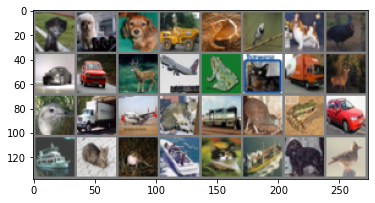

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
print(images.shape)
CHANNELS, HEIGHT, WIDTH = images.shape[1:]

torch.Size([32, 3, 32, 32])


## **Baseline Model** 

The most straight forward approach is to simply **flatten** the image into a vector and feed it into **a basic MLP Neural network**. This may serve as a baseline. We flatten starting from the fist dimension, as dimension 0 is the batch dimension and is automatically handled by PyTorch. The expected output size is $batchsize\times (channels*height*width)=32\times 3072$.

In [6]:
images.flatten(start_dim=1).shape

torch.Size([32, 3072])

<figure align="center">
<img src='https://viso.ai/wp-content/uploads/2021/04/multilayer-perceptrons-MLP-concept-1.jpg' width="600" height="300">
</figure>


In PyTorch, neural networks typically are defined as a class which inherits from nn.Module. In the constructor of the class, the different components of the network are defined (e.g. the different layers) and the forward function implements the forward pass through the network. 

In [7]:
class MLP(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x

In [8]:
def initialize_baseline_model(feature_count, hidden_layer_size, class_count):
  baseline_model = MLP(feature_count, hidden_layer_size, class_count)
  baseline_model = baseline_model.to(device)
  return baseline_model

feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

To make sure the model is working we'll run a forward pass through the network to compute its predictions.

We most of the time call model outputs (probabilities in this case) as logits. The next step is to pass these logits to a loss function from which the gradients can be computed.

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

logits = baseline_model.forward(images.flatten(start_dim=1).to(device))

print('Logits shape:',logits.shape)

Logits shape: torch.Size([32, 10])


## **Loss Function** 

To train our network we need some way to measure the error between the output of the network and the label encoded into a one-hot representation. We measure the cross-entropy between them. Parameter *m* in the equation below is number of classes.

<figure align="center">
<img src='https://miro.medium.com/max/1122/1*KY8QcvVOz1sdUnVKKhxWyA@2x.png' width="250" height="100">
</figure>


In [10]:
CE_criterian = nn.CrossEntropyLoss()

## **Optimizers** 

We have our network and a way of computing the error of its output with respect to labels. Now we just need something to optimize the network's weights. PyTorch provides a number of optimizers which can be directly used and customized. The standard optimizer is the SGD (Stochastic gradient descent) optimizer. Adam can also be a good default choice. 

In [11]:
Learning_rate = 0.005
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

## **Validation** 

During the training, we optimize the cross-entropy loss. Most of the times, we are rather interested in a different metric such as accuracy or recall in order to measure the performance of the model. This can be done during the validation. Validation can be either computed on the training or on the validation dataset (which is more common). By computing the accuracy on the validation set we get a first impression how the model performs on unseen data. 

We need now to define a validation method for our model. A method to measure the accuracy on the validation set. 

This function takes:
*   Trained model
*   Test dataloader

and returns:
*   Test accuracy




In [12]:
def validate_model(model: torch.nn.Module, data, flatten_flag=True):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        for batch, labels in data:
            labels = labels.to(device)
            
            if flatten_flag:
              predictions = model(batch.to(device).flatten(start_dim=1))
            else:
              predictions = model(batch.to(device))

            predictions = predictions.argmax(dim=1)
            top_1 = predictions==labels
            top_1 = top_1.type(torch.float)
            top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

# OR just take a single (batch,labels) pair and return accuracy. This will be usefull next for training loop.

def validate_single_batch(model: torch.nn.Module, batch, labels):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        predictions = model(batch)
        predictions = predictions.argmax(dim=1)
        top_1 = predictions==labels
        top_1 = top_1.type(torch.float)
        top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

One way to visualize what the notebook has learned is to visualize the output distribution of the network depended on the input. You can use this method after each experiment in order to have a look what the model has learned.

In [13]:
def show_output_distributions(model, data, flatten=True):
    rows, cols = 2,5
    device = next(model.parameters()).device
    with torch.no_grad():
        fig = plt.figure(figsize=(20,5))
        for i in range(1, rows*cols+1):
            image, label = data[i-1]
            image = image.unsqueeze(0)
            image = image.to(device)
            if flatten:
                image = image.flatten(start_dim=1)
            prediction = model(image)
            ax = fig.add_subplot(rows,cols,i)
            ax.bar(range(10),prediction.detach().squeeze().cpu().numpy())
            ax.set_title(f"Label: {label}")
            ax.set_xlabel("Predicted Labels")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
  

Let's experiment our untrained model and understand what the output of the default model looks like.

Why do you think the accuracy is always around 0.1 for untrained model?

In [14]:
validation_score = validate_model(baseline_model, testloader)
print(f"The untrained model has a validation score of {validation_score}")

The untrained model has a validation score of 0.08286741375923157


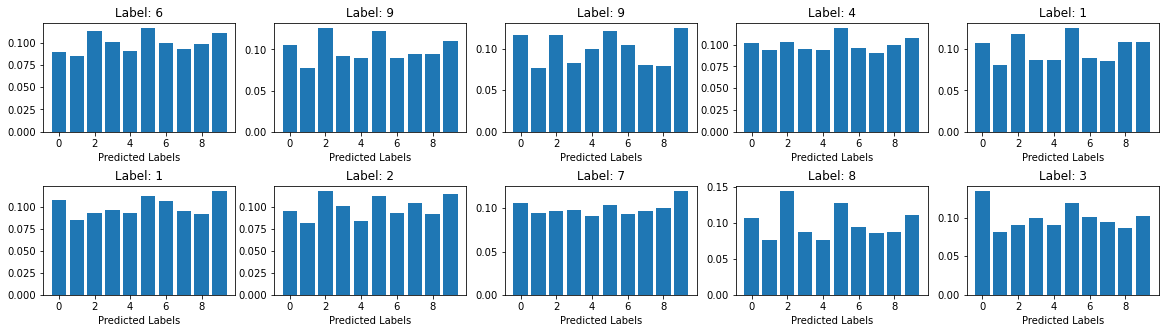

In [15]:
show_output_distributions(baseline_model, trainset)

## **Training** 

We need now to combine everything in a single training loop. Training loop will update my model weights to enhance its accuracy.

This loop should take as an argument:
1.   Epochs count
2.   Model
3.   Train Dataloader
4.   Optimizer
5.   Loss Function

and should return:
1.   Trained model
2.   Epoch logs (training loss, training accuracy, weight histograms)




In [16]:
def train_model(epochs, model, dataloader_train, dataloader_val, optimizer, loss_function, writer, flatten_flag=True, val_step=2, identifier=None):
    
    if not TRAIN_IN_NOTEBOOK:
        assert identifier is not None, "Need to pass identifier to load correct model"
        model = torch.load(path.join("lecture_models", identifier, identifier + "_model.pt"), map_location=device)
        return model, None, None

    # To log the loss
    epoch_loss = []
    epoch_acc = []

    for epoch in range(epochs):
        model.train()
        cur_loss = []
        cur_acc = []

        for batch_idx, (batch, labels) in enumerate(dataloader_train):
          
            if flatten_flag:
              batch, labels = Variable(batch).to(device).flatten(start_dim=1), Variable(labels).to(device)
            else:
              batch, labels = Variable(batch).to(device), Variable(labels).to(device)

            #Reset the optimizer 
            optimizer.zero_grad() 
            prediction = model(batch)
            loss = loss_function(prediction, labels)
            #Backpropagate the error
            loss.backward()
            #Update the weights based on the error
            optimizer.step()

            cur_acc.append(validate_single_batch(model, batch, labels))
            cur_loss.append(loss.item())

        # Validate the model every n-th episonde
        if epoch % val_step == 0:
            val_score = validate_model(model, dataloader_val, flatten_flag)
            print(f"Validation socore after epoch {epoch}: {val_score:.3f}")
            writer.add_scalar("Acc/val", val_score, epoch//val_step)

        epoch_loss.append(np.mean(cur_loss))
        epoch_acc.append(np.mean(cur_acc))
        
        for name, layer in model.named_children():
            if hasattr(layer, "weight"):
                writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
                writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
        writer.add_scalar("Loss/train", epoch_loss[-1], epoch)
        writer.add_scalar("Acc/train", epoch_acc[-1], epoch)

        print(f"Finished epoch {epoch+1}: Loss= {epoch_loss[-1]}, Accuracy= {epoch_acc[-1]}")
    return model, epoch_loss, epoch_acc


## **Training Experiments** 

There are multiple approaches on how to improve the model performance, these can roughly be categorized into 2 categories:
- Improve the training procedure
    - Change/adapt the optimizer (Learning rate, momentum, different optimizer, regularization)
    - Data related changes (data augmentation to benefit more from existing data, change batchsize)
- Improve the model architecture / model related changes
    - Change width/depth of the model
    - Use a different type of model (CNN instead of MLP)
    - Include skip connections

This list is not extensive and there are no boundaries to your imagination on what to change. The presented experiments are only examples and there might very well be a setting which outperforms the currently presented examples. You might want to try SGD with momentum or the Adam optimizer for instance. Feel free to run your own experiments.

We define the number of epochs for how long the model should be trained. Depended on your GPU/CPU it can take quite long to train a single epoch.

In [17]:
epochs = 2

#### **Baseline** 
Train the baseline model. Each experiment has a unique identifier under which we safe it's logs and the final model.

In [18]:
identifier = 'Baseline_SGD_lr005_CE'
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr005_CE model has a validation score of 0.4678514301776886


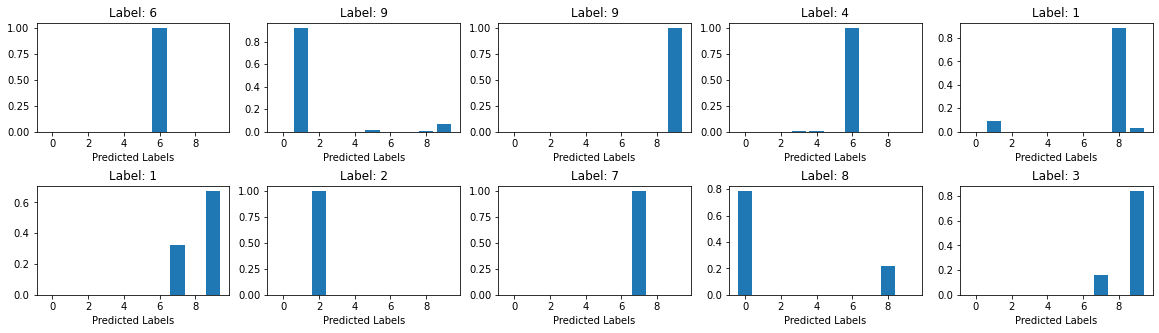

In [19]:
show_output_distributions(exp_model, trainset)

### **Improve the training procedure**
#### **Changes in learning rate** 


##### **Decrease the lr (0.0005)** 

In [20]:
identifier = "Baseline_SGD_lr0005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

SGD_optimizer_0005 = optim.SGD(baseline_model.parameters(), 0.0005)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_0005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr0005_CE model has a validation score of 0.38298723101615906


##### **Increase the large lr (0.5)** 

In [21]:
## Initialize again baseline model ##
identifier = "Baseline_SGD_lr05_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

SGD_optimizer_05 = optim.SGD(baseline_model.parameters(), 0.5)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_05, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr05_CE model has a validation score of 0.3764975965023041


#### **Changes in Batch Size** 

##### **Reduce batch size to 4** 

In [22]:
trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True,
                                        download=True, transform=transform)
trainloader_BS4 = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

identifier = "Baseline_SGD_lr005_CE_BS4"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS4, testloader, SGD_optimizer, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

Files already downloaded and verified
The Baseline_SGD_lr005_CE_BS4 model has a validation score of 0.4732428193092346


##### **Increase batch size to 128** 

In [23]:
trainloader_BS128 = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

identifier = "Baseline_SGD_lr005_CE_BS128"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS128, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr005_CE_BS128 model has a validation score of 0.41164135932922363


##### **Given the large batch size, can we improve the performance by increase the learning rate?** 

In [24]:
identifier = "Baseline_SGD_lr05_CE_BS128"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), 0.05)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS128, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr05_CE_BS128 model has a validation score of 0.46855032444000244


##### **Is a smaller batch size always better?** 
In theory this is not true, as a smaller batch size gives less exposure to the training distribution. In this toy example however the effect that we do more gradient updates seems to dominate.

In [25]:
trainloader_BS2 = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, num_workers=2)

identifier = "Baseline_SGD_lr005_CE_BS2"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS2, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr005_CE_BS2 model has a validation score of 0.4794329106807709


### **Data Augmentations** 
The basic idea of data augmentation is to present the same image in various shapes, forms and colors. By adding noise, we hope that the networks becomes more robust against noise in unseen images. 

In [26]:
## Added torchvision.transforms.RandomHorizontalFlip()

transform = transforms.Compose(
    [transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##

trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Initialize again baseline model ##
identifier = "Baseline_SGD_lr005_CE_Aug"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

Files already downloaded and verified
Files already downloaded and verified
The Baseline_SGD_lr005_CE_Aug model has a validation score of 0.4742412269115448


### **Changes in the Model** 

#### **Initialization** 
As the initialization provides the starting point of the optimization, changing the starting point may lead to a better outcome. 

Finding a good initialization outperforming random initialization is however very difficult. Here we examine the question why we need random initialization. 

In [27]:
# What happens if we initialize all the weights with zeros?
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
for layer in baseline_model.children():
    if hasattr(layer,"weight"):
        layer.weight = torch.nn.Parameter(torch.zeros_like(layer.weight))
        layer.bias = torch.nn.Parameter(torch.zeros_like(layer.bias))


identifier = "Baseline_SGD_lr005_CE_Zeroinit"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)
writer = SummaryWriter(path.join(path_to_logs, "Baseline_SGD_lr005_CE_Zeroinit"))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr005_CE_Zeroinit model has a validation score of 0.09994009882211685


#### **Dropouts** 
Dropout is a further way to regularize the network.

In [28]:
class MLP_withdropout(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_withdropout, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.25) # added
    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.dropout(x) # not a good practise to drop out on the first layer
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x

## Initialize the model ##
identifier = "Baseline_SGD_lr005_CE_Drop"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_with_dropouts = MLP_withdropout(feature_count, hidden_layer_size, class_count).to(device)
SGD_optimizer_005 = optim.SGD(baseline_with_dropouts.parameters(), Learning_rate)


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_with_dropouts, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The Baseline_SGD_lr005_CE_Drop model has a validation score of 0.3791932761669159


#### **Changes in model size**
Model changes can either be by increasing the width of the layers or by adding more layers. Both approaches increase the complexity of the learner in different ways.
##### **Increase model size by increasing the hidden layer size from 36 to 128**

In [29]:
identifier = "MLP_wide_SGD_lr005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

baseline_model = initialize_baseline_model(feature_count, 128, class_count)

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), 0.005)

nof_params_orig = sum([tensor.numel() for tensor in initialize_baseline_model(feature_count, hidden_layer_size, class_count).parameters()])
nof_params_wide = sum([tensor.numel() for tensor in baseline_model.parameters()])

print(f"The standard model has {nof_params_orig:,} parameters. The wide model has {nof_params_wide:,} parameters")

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The standard model has 110,998 parameters. The wide model has 394,634 parameters
The MLP_wide_SGD_lr005_CE model has a validation score of 0.5006988644599915


##### **Increase model size by increasing the number of layers**
Include one more hidden layer.

In [30]:
class MLP_2layer(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_2layer, self).__init__()
        intermediate_size =  (feature_count + hidden_layer_size)//2
        
        self.hidden_lay_1 = nn.Linear(feature_count, intermediate_size)
        self.activation_1 = nn.ReLU()
        self.hidden_lay_2 = nn.Linear(intermediate_size, hidden_layer_size)
        self.activation_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_3 = nn.Softmax(dim=0)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_lay_1(x)
        x = self.activation_1(x)
        x = self.hidden_lay_2(x)
        x = self.activation_2(x)
        x = self.output_layer(x)
        x = self.activation_3(x)
        return x

In [31]:
## Initialize increase the size from. ##
identifier = "MLP_deep_SGD_lr005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

deep_model = MLP_2layer(feature_count, hidden_layer_size, class_count).to(device)

SGD_optimizer_005 = optim.SGD(deep_model.parameters(), Learning_rate)

nof_params_orig = sum([tensor.numel() for tensor in initialize_baseline_model(feature_count, hidden_layer_size, class_count).parameters()])
nof_params_deep = sum([tensor.numel() for tensor in deep_model.parameters()])
print(f"The standard model has {nof_params_orig:,} parameters. The deep model has {nof_params_deep:,} parameters")


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, deep_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader)
print(f"The {identifier} model has a validation score of {validation_score}")

The standard model has 110,998 parameters. The deep model has 4,831,792 parameters
The MLP_deep_SGD_lr005_CE model has a validation score of 0.39087459444999695


##### **Change the model architecture from MLP to CNN** 
CNNs were designed to make use of the given spatial structure of the image. This already given structure is lost in the MLP by flattening the image. 

In [32]:
class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x,dim=1)
        return x

In [33]:
identifier = "CNN_SGD_lr005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

CNN_MODEL = CNN_Net().to(device)
SGD_optimizer_005 = optim.SGD(CNN_MODEL.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, CNN_MODEL, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, flatten_flag=False, identifier=identifier)

if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, testloader, flatten_flag=False)
print(f"The {identifier} model has a validation score of {validation_score}")

/Users/ajaus/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The CNN_SGD_lr005_CE model has a validation score of 0.5613019466400146


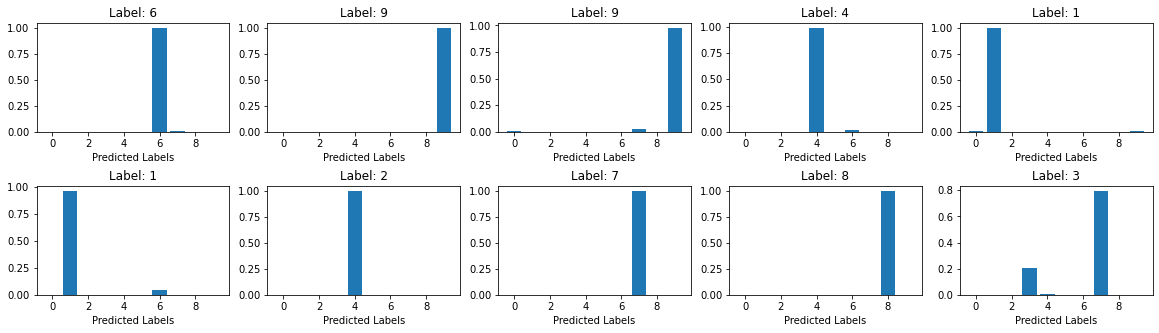

In [34]:
show_output_distributions(exp_model, trainset, flatten=False)

## **Activation maximization**
One way to visualize what is happening in the network is modify the input shuch that the output of the network is maximal.

In [35]:
import ActMax.act_max_util as amu

In [36]:
example_model = "lecture_models/CNN_SGD_lr005_CE/CNN_SGD_lr005_CE_model.pt"
model = torch.load(example_model, map_location=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


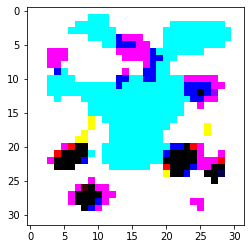

In [37]:
input = torch.randn(3, 32, 32)
input = input.unsqueeze(0)
input.requires_grad_(True)
# input dimmensions become (1, 3, 227, 227)

activation_dictionary = {}
layer_name = 'fc3'

model.fc3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

steps = 1000                 # perform 100 iterations
unit = 9                    # car class of cifar
alpha = torch.tensor(10)   # learning rate (step size) 
verbose = True              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = True        # enable Gaussian regularizer
Norm_Crop = True            # enable norm regularizer
Contrib_Crop = True         # enable contribution regularizer

output = amu.act_max(network=model,
                input=input,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=False,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                )

final_image = amu.image_converter(output.squeeze(0))
final_image = final_image * 255
plt.imshow(final_image)

Short training time and low resolution make it difficult to make use of this visualization technique. To get a better understanding of this technique. we use an image classifier which has been trained on larger images and performs well. It is the AlexNet which won the ImageNet classification task in 2012. The class for which we want to optimize the input is the flamingo class, if you want to compute it for another class, change unit ```unit = 130``` to another class. You can view the class defintions here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


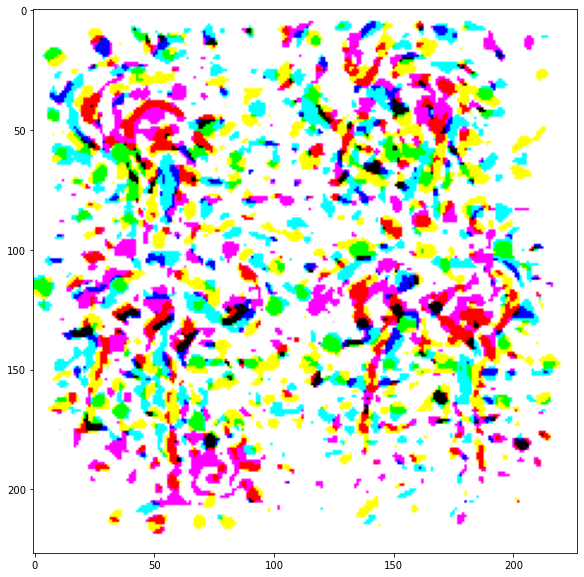

In [38]:
alexnet = torchvision.models.alexnet(pretrained=True)

input = torch.randn(3, 227, 227)
input = input.unsqueeze(0)
input.requires_grad_(True)
# input dimmensions become (1, 3, 227, 227)

activation_dictionary = {}
layer_name = 'classifier_6'

alexnet.classifier[-1].register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

steps = 250                 # perform 100 iterations
unit = 130                  # flamingo class of Imagenet
alpha = torch.tensor(100)   # learning rate (step size) 
verbose = False              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = True        # enable Gaussian regularizer
Norm_Crop = True            # enable norm regularizer
Contrib_Crop = True         # enable contribution regularizer

output = amu.act_max(network=alexnet,
                input=input,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                )

final_image = amu.image_converter(output.squeeze(0))
final_image = final_image * 255
plt.figure(figsize=(10,10))
plt.imshow(final_image)

With some imagination flamingos can be recongized. 